O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v1.4

SETUP:

    In[NOx, VOC, NH3]
    Out[pred. O3]

STRUCTURE:

    CMAQ U-Net (w/o Conditional)

    model = build_model(
        ..., 
        ~~emb_dims=[64],~~
        ...,
        hidden_size=[128, 96],
        ...,
        in_filters=10,
        ...
    )

PARAMETER:

    EPOCH = 1000
    Lr = 1e-3
    test_split = 0.4

In [6]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# Training

In [7]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_matrix_2013_for_o3.csv')
# dataset_2013['Boundary'] = 1.0

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data = ctrl_data[:, :17*3]
# -------------
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'

label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))

label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [8]:
from src.model.cmaqnet_unet import build_model

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, y_train, y_test = train_test_split(emis_data, label_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*3,
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=10,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanAbsoluteError(),
    )
    
# define callback
def scheduler(epoch, lr):
    # if epoch <= 1000: return 2.5e-3
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/1000
INFO:tensorflow:Collective all_reduce tensors: 66 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 66 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


2025-02-27 14:18:47.805388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:47.822822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:47.847667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:47.873791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 14:18:50.616606: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f62cac96a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 14:18:50.616659: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 14:18:50.616673: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 14:18:50.61668

3/3 [==============================] - ETA: 0s - loss: 0.0919 INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-01-0.0357/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-01-0.0357/assets


3/3 [==============================] - 38s 6s/step - loss: 0.0919 - val_loss: 0.0357 - lr: 0.0010
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.0403INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-02-0.0290/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-02-0.0290/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0403 - val_loss: 0.0290 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.0225INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-03-0.0223/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-03-0.0223/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0225 - val_loss: 0.0223 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.0149INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-04-0.0216/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-04-0.0216/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0149 - val_loss: 0.0216 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0134 - val_loss: 0.0239 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0111 - val_loss: 0.0284 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0097 - val_loss: 0.0297 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0089 - val_loss: 0.0307 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0093 - val_loss: 0.0307 - lr: 0.0010
Epoch 10/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0085 - val_loss: 0.0313 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0078 - val_loss: 0.0321 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0075 - val_loss: 0.0348 - lr: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-50-0.0209/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0060 - val_loss: 0.0209 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0061 - val_loss: 0.0234 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0062 - val_loss: 0.0216 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0056 - val_loss: 0.0217 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0054 - val_loss: 0.0236 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 0.0060INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-55-0.0203/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-55-0.0203/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0060 - val_loss: 0.0203 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0057 - val_loss: 0.0228 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 0.0048INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-57-0.0191/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-57-0.0191/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0048 - val_loss: 0.0191 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0053 - val_loss: 0.0210 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 0.0062INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-59-0.0182/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-59-0.0182/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0062 - val_loss: 0.0182 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0054 - val_loss: 0.0207 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 0.0060INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-61-0.0172/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-61-0.0172/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0060 - val_loss: 0.0172 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0058 - val_loss: 0.0197 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0053 - val_loss: 0.0186 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0048 - val_loss: 0.0188 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0046 - val_loss: 0.0195 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0047 - val_loss: 0.0177 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - 1s 237ms/step - loss: 0.0046 - val_loss: 0.0185 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - 1s 248ms/step - loss: 0.0042 - val_loss: 0.0182 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0042 - val_loss: 0.0174 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-72-0.0148/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0041 - val_loss: 0.0148 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0053 - val_loss: 0.0176 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 0.0047INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-74-0.0137/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-74-0.0137/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0047 - val_loss: 0.0137 - lr: 0.0010
Epoch 75/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0046 - val_loss: 0.0151 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0039 - val_loss: 0.0168 - lr: 0.0010
Epoch 77/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0037 - val_loss: 0.0164 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0037 - val_loss: 0.0154 - lr: 0.0010
Epoch 79/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0042 - val_loss: 0.0146 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-80-0.0137/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-80-0.0137/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0035 - val_loss: 0.0137 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-81-0.0120/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-81-0.0120/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0038 - val_loss: 0.0120 - lr: 0.0010
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-82-0.0106/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-82-0.0106/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0036 - val_loss: 0.0106 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0041 - val_loss: 0.0125 - lr: 0.0010
Epoch 84/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0038 - val_loss: 0.0121 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0039 - val_loss: 0.0118 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0040 - val_loss: 0.0129 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0036 - val_loss: 0.0114 - lr: 0.0010
Epoch 88/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0040 - val_loss: 0.0110 - lr: 0.0010
Epoch 89/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0034 - val_loss: 0.0114 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0038 - val_loss: 0.0108 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-91-0.0098/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0032 - val_loss: 0.0098 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0032 - val_loss: 0.0105 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-93-0.0092/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-93-0.0092/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0034 - val_loss: 0.0092 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 0.0037INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-94-0.0085/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-94-0.0085/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0037 - val_loss: 0.0085 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0042 - val_loss: 0.0098 - lr: 0.0010
Epoch 96/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-96-0.0078/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-96-0.0078/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0036 - val_loss: 0.0078 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-97-0.0068/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-97-0.0068/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0035 - val_loss: 0.0068 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0039 - val_loss: 0.0085 - lr: 0.0010
Epoch 99/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0036 - val_loss: 0.0080 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0037 - val_loss: 0.0081 - lr: 0.0010
Epoch 101/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0034 - val_loss: 0.0092 - lr: 0.0010
Epoch 102/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0036 - val_loss: 0.0088 - lr: 0.0010
Epoch 103/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0034 - val_loss: 0.0086 - lr: 0.0010
Epoch 104/1000
3/3 [==============================] - 0s 177ms/step - loss: 0.0037 - val_loss: 0.0076 - lr: 0.0010
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-105-0.0058/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0034 - val_loss: 0.0058 - lr: 0.0010
Epoch 106/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0033 - val_loss: 0.0065 - lr: 0.0010
Epoch 107/1000
3/3 [==============================] - 0s 172ms/step - loss: 0.0031 - val_loss: 0.0073 - lr: 0.0010
Epoch 108/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0031 - val_loss: 0.0078 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0029 - val_loss: 0.0083 - lr: 0.0010
Epoch 110/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0029 - val_loss: 0.0085 - lr: 0.0010
Epoch 111/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0029 - val_loss: 0.0077 - lr: 0.0010
Epoch 112/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0031 - val_loss: 0.0068 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0028 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-114-0.0056/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0030 - val_loss: 0.0056 - lr: 0.0010
Epoch 115/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-115-0.0055/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-115-0.0055/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0035 - val_loss: 0.0055 - lr: 0.0010
Epoch 116/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0030 - val_loss: 0.0068 - lr: 0.0010
Epoch 117/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0038 - val_loss: 0.0083 - lr: 0.0010
Epoch 118/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0037 - val_loss: 0.0075 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0030 - val_loss: 0.0064 - lr: 0.0010
Epoch 120/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0033 - val_loss: 0.0059 - lr: 0.0010
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-121-0.0050/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-121-0.0050/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0036 - val_loss: 0.0050 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-122-0.0040/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-122-0.0040/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0035 - val_loss: 0.0040 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0038 - val_loss: 0.0061 - lr: 0.0010
Epoch 124/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0037 - val_loss: 0.0050 - lr: 0.0010
Epoch 125/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0036 - val_loss: 0.0062 - lr: 0.0010
Epoch 126/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0035 - val_loss: 0.0078 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0038 - val_loss: 0.0074 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0034 - val_loss: 0.0079 - lr: 0.0010
Epoch 129/1000
3/3 [==============================] - 0s 175ms/step - loss: 0.0036 - val_loss: 0.0066 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - 0s 173ms/step - loss: 0.0039 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-139-0.0039/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0031 - val_loss: 0.0039 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0027 - val_loss: 0.0046 - lr: 0.0010
Epoch 141/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0027 - val_loss: 0.0057 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0029 - val_loss: 0.0068 - lr: 0.0010
Epoch 143/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0028 - val_loss: 0.0080 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0025 - val_loss: 0.0074 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0024 - val_loss: 0.0071 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - 0s 174ms/step - loss: 0.0025 - val_loss: 0.0052 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-147-0.0037/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0029 - val_loss: 0.0037 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0035 - val_loss: 0.0038 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0029 - val_loss: 0.0042 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0029 - val_loss: 0.0054 - lr: 0.0010
Epoch 151/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0026 - val_loss: 0.0053 - lr: 0.0010
Epoch 152/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0024 - val_loss: 0.0047 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0025 - val_loss: 0.0049 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0023 - val_loss: 0.0045 - lr: 0.0010
Epoch 155/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0023 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-169-0.0033/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0028 - val_loss: 0.0033 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - ETA: 0s - loss: 0.0026INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-170-0.0032/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-170-0.0032/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0026 - val_loss: 0.0032 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0024 - val_loss: 0.0035 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0027 - val_loss: 0.0043 - lr: 0.0010
Epoch 173/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0027 - val_loss: 0.0050 - lr: 0.0010
Epoch 174/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0027 - val_loss: 0.0053 - lr: 0.0010
Epoch 175/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0023 - val_loss: 0.0059 - lr: 0.0010
Epoch 176/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0024 - val_loss: 0.0052 - lr: 0.0010
Epoch 177/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0026 - val_loss: 0.0037 - lr: 0.0010
Epoch 178/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0026 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-193-0.0032/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0023 - val_loss: 0.0032 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - ETA: 0s - loss: 0.0021INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-194-0.0032/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-194-0.0032/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0021 - val_loss: 0.0032 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - ETA: 0s - loss: 0.0023INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-195-0.0031/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-195-0.0031/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0023 - val_loss: 0.0031 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0020 - val_loss: 0.0034 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 177ms/step - loss: 0.0021 - val_loss: 0.0039 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0021 - val_loss: 0.0032 - lr: 0.0010
Epoch 199/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0023 - val_loss: 0.0033 - lr: 0.0010
Epoch 200/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0023 - val_loss: 0.0035 - lr: 0.0010
Epoch 201/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0022 - val_loss: 0.0040 - lr: 0.0010
Epoch 202/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0022 - val_loss: 0.0036 - lr: 0.0010
Epoch 203/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0022 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-210-0.0030/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0018 - val_loss: 0.0030 - lr: 0.0010
Epoch 211/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0018 - val_loss: 0.0034 - lr: 0.0010
Epoch 212/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0017 - val_loss: 0.0037 - lr: 0.0010
Epoch 213/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0017 - val_loss: 0.0035 - lr: 0.0010
Epoch 214/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0016 - val_loss: 0.0030 - lr: 0.0010
Epoch 215/1000
3/3 [==============================] - ETA: 0s - loss: 0.0016INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-215-0.0029/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-215-0.0029/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0016 - val_loss: 0.0029 - lr: 0.0010
Epoch 216/1000
3/3 [==============================] - ETA: 0s - loss: 0.0017INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-216-0.0029/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-216-0.0029/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0017 - val_loss: 0.0029 - lr: 0.0010
Epoch 217/1000
3/3 [==============================] - ETA: 0s - loss: 0.0018INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-217-0.0028/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-217-0.0028/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0018 - val_loss: 0.0028 - lr: 0.0010
Epoch 218/1000
3/3 [==============================] - ETA: 0s - loss: 0.0019INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-218-0.0025/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-218-0.0025/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0019 - val_loss: 0.0025 - lr: 0.0010
Epoch 219/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0018 - val_loss: 0.0030 - lr: 0.0010
Epoch 220/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0016 - val_loss: 0.0027 - lr: 0.0010
Epoch 221/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0017 - val_loss: 0.0026 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0017 - val_loss: 0.0028 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0017 - val_loss: 0.0026 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0019 - val_loss: 0.0035 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0023 - val_loss: 0.0029 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0022 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-242-0.0025/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0015 - val_loss: 0.0025 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - ETA: 0s - loss: 0.0016INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-243-0.0024/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-243-0.0024/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0016 - val_loss: 0.0024 - lr: 0.0010
Epoch 244/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0017 - val_loss: 0.0026 - lr: 0.0010
Epoch 245/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0014 - val_loss: 0.0027 - lr: 0.0010
Epoch 246/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0017 - val_loss: 0.0028 - lr: 0.0010
Epoch 247/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0019 - val_loss: 0.0024 - lr: 0.0010
Epoch 248/1000
3/3 [==============================] - ETA: 0s - loss: 0.0017INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-248-0.0020/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-248-0.0020/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0017 - val_loss: 0.0020 - lr: 0.0010
Epoch 249/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0023 - val_loss: 0.0029 - lr: 0.0010
Epoch 250/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0020 - val_loss: 0.0028 - lr: 0.0010
Epoch 251/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0016 - val_loss: 0.0027 - lr: 0.0010
Epoch 252/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0014 - val_loss: 0.0030 - lr: 0.0010
Epoch 253/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0014 - val_loss: 0.0029 - lr: 0.0010
Epoch 254/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0013 - val_loss: 0.0028 - lr: 0.0010
Epoch 255/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0014 - val_loss: 0.0028 - lr: 0.0010
Epoch 256/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0015 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-285-0.0019/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0017 - val_loss: 0.0019 - lr: 0.0010
Epoch 286/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0018 - val_loss: 0.0021 - lr: 0.0010
Epoch 287/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0014 - val_loss: 0.0026 - lr: 0.0010
Epoch 288/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0015 - val_loss: 0.0032 - lr: 0.0010
Epoch 289/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0015 - val_loss: 0.0030 - lr: 0.0010
Epoch 290/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0018 - val_loss: 0.0029 - lr: 0.0010
Epoch 291/1000
3/3 [==============================] - 1s 241ms/step - loss: 0.0016 - val_loss: 0.0028 - lr: 0.0010
Epoch 292/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0017 - val_loss: 0.0026 - lr: 0.0010
Epoch 293/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0017 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-303-0.0018/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0015 - val_loss: 0.0018 - lr: 0.0010
Epoch 304/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0014 - val_loss: 0.0021 - lr: 0.0010
Epoch 305/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0013 - val_loss: 0.0023 - lr: 0.0010
Epoch 306/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0015 - val_loss: 0.0022 - lr: 0.0010
Epoch 307/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0012 - val_loss: 0.0026 - lr: 0.0010
Epoch 308/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0012 - val_loss: 0.0024 - lr: 0.0010
Epoch 309/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0011 - val_loss: 0.0022 - lr: 0.0010
Epoch 310/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0011 - val_loss: 0.0026 - lr: 0.0010
Epoch 311/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0012 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-332-0.0017/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0013 - val_loss: 0.0017 - lr: 0.0010
Epoch 333/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0013 - val_loss: 0.0020 - lr: 0.0010
Epoch 334/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0013 - val_loss: 0.0020 - lr: 0.0010
Epoch 335/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0015 - val_loss: 0.0022 - lr: 0.0010
Epoch 336/1000
3/3 [==============================] - 0s 174ms/step - loss: 0.0011 - val_loss: 0.0020 - lr: 0.0010
Epoch 337/1000
3/3 [==============================] - ETA: 0s - loss: 0.0012    INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-337-0.0015/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-337-0.0015/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0012 - val_loss: 0.0015 - lr: 0.0010
Epoch 338/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0013 - val_loss: 0.0024 - lr: 0.0010
Epoch 339/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0015 - val_loss: 0.0020 - lr: 0.0010
Epoch 340/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0012 - val_loss: 0.0018 - lr: 0.0010
Epoch 341/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0013 - val_loss: 0.0020 - lr: 0.0010
Epoch 342/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0014 - val_loss: 0.0021 - lr: 0.0010
Epoch 343/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0014 - val_loss: 0.0022 - lr: 0.0010
Epoch 344/1000
3/3 [==============================] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-344-0.0015/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-344-0.0015/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0013 - val_loss: 0.0015 - lr: 0.0010
Epoch 345/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0014 - val_loss: 0.0018 - lr: 0.0010
Epoch 346/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0013 - val_loss: 0.0022 - lr: 0.0010
Epoch 347/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0013 - val_loss: 0.0022 - lr: 0.0010
Epoch 348/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0011 - val_loss: 0.0019 - lr: 0.0010
Epoch 349/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0014 - val_loss: 0.0017 - lr: 0.0010
Epoch 350/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0016 - val_loss: 0.0024 - lr: 0.0010
Epoch 351/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0013 - val_loss: 0.0020 - lr: 0.0010
Epoch 352/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0012 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-395-0.0014/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0010
Epoch 396/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0015 - val_loss: 0.0024 - lr: 0.0010
Epoch 397/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0013 - val_loss: 0.0018 - lr: 0.0010
Epoch 398/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0010 - val_loss: 0.0018 - lr: 0.0010
Epoch 399/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0012 - val_loss: 0.0016 - lr: 0.0010
Epoch 400/1000
3/3 [==============================] - 0s 200ms/step - loss: 9.1822e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 401/1000
3/3 [==============================] - 0s 185ms/step - loss: 9.3662e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 402/1000
3/3 [==============================] - 0s 176ms/step - loss: 9.9902e-04 - val_loss: 0.0021 - lr: 0.0010
Epoch 403/1000
3/3 [==============================] - 0s 176ms/step - loss: 9.9296e-04

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-406-0.0014/assets


3/3 [==============================] - 7s 3s/step - loss: 8.1821e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 407/1000
3/3 [==============================] - ETA: 0s - loss: 8.2738e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-407-0.0013/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-407-0.0013/assets


3/3 [==============================] - 9s 4s/step - loss: 8.2738e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 408/1000
3/3 [==============================] - ETA: 0s - loss: 9.2981e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-408-0.0012/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-408-0.0012/assets


3/3 [==============================] - 7s 3s/step - loss: 9.2981e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 409/1000
3/3 [==============================] - 0s 200ms/step - loss: 9.7373e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 410/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0011 - val_loss: 0.0017 - lr: 0.0010
Epoch 411/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0012 - val_loss: 0.0019 - lr: 0.0010
Epoch 412/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0013 - val_loss: 0.0015 - lr: 0.0010
Epoch 413/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0013 - val_loss: 0.0015 - lr: 0.0010
Epoch 414/1000
3/3 [==============================] - 0s 194ms/step - loss: 9.3980e-04 - val_loss: 0.0021 - lr: 0.0010
Epoch 415/1000
3/3 [==============================] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-415-0.00

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-415-0.0012/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 416/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0013 - val_loss: 0.0015 - lr: 0.0010
Epoch 417/1000
3/3 [==============================] - 0s 192ms/step - loss: 9.8307e-04 - val_loss: 0.0024 - lr: 0.0010
Epoch 418/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010
Epoch 419/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0013 - val_loss: 0.0019 - lr: 0.0010
Epoch 420/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0012 - val_loss: 0.0020 - lr: 0.0010
Epoch 421/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0011 - val_loss: 0.0017 - lr: 0.0010
Epoch 422/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0010 - val_loss: 0.0019 - lr: 0.0010
Epoch 423/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0012 - val_loss:

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-430-0.0011/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0012 - val_loss: 0.0011 - lr: 0.0010
Epoch 431/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 432/1000
3/3 [==============================] - 0s 184ms/step - loss: 9.5398e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 433/1000
3/3 [==============================] - 0s 177ms/step - loss: 0.0010 - val_loss: 0.0018 - lr: 0.0010
Epoch 434/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0012 - val_loss: 0.0018 - lr: 0.0010
Epoch 435/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 436/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0011 - val_loss: 0.0014 - lr: 0.0010
Epoch 437/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0011 - val_loss: 0.0020 - lr: 0.0010
Epoch 438/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0011 - val_loss:

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-444-0.0011/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0011 - val_loss: 0.0011 - lr: 0.0010
Epoch 445/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0011 - val_loss: 0.0019 - lr: 0.0010
Epoch 446/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0012 - val_loss: 0.0018 - lr: 0.0010
Epoch 447/1000
3/3 [==============================] - 0s 189ms/step - loss: 9.6736e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 448/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 449/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0012 - val_loss: 0.0019 - lr: 0.0010
Epoch 450/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0010 - val_loss: 0.0021 - lr: 0.0010
Epoch 451/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0011 - val_loss: 0.0014 - lr: 0.0010
Epoch 452/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0012 - val_loss:

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-515-0.0010/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0010 - val_loss: 9.8361e-04 - lr: 0.0010
Epoch 516/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0010 - val_loss: 0.0012 - lr: 0.0010
Epoch 517/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0011 - val_loss: 0.0014 - lr: 0.0010
Epoch 518/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0010 - val_loss: 0.0014 - lr: 0.0010
Epoch 519/1000
3/3 [==============================] - 0s 221ms/step - loss: 8.7268e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 520/1000
3/3 [==============================] - 1s 235ms/step - loss: 0.0011 - val_loss: 0.0015 - lr: 0.0010
Epoch 521/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0010 - val_loss: 0.0014 - lr: 0.0010
Epoch 522/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0010 - val_loss: 0.0015 - lr: 0.0010
Epoch 523/1000
3/3 [==============================] - 0s 219ms/step - loss: 9.8676e-04 - v

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-540-0.0009/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0011 - val_loss: 9.0948e-04 - lr: 0.0010
Epoch 541/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0012 - val_loss: 0.0017 - lr: 0.0010
Epoch 542/1000
3/3 [==============================] - 0s 204ms/step - loss: 9.8280e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 543/1000
3/3 [==============================] - 0s 201ms/step - loss: 9.1468e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 544/1000
3/3 [==============================] - 0s 187ms/step - loss: 9.9009e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 545/1000
3/3 [==============================] - 0s 211ms/step - loss: 8.5877e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 546/1000
3/3 [==============================] - 0s 174ms/step - loss: 9.6377e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 547/1000
3/3 [==============================] - 0s 177ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 548/1000
3/3 [==============================] - 0s 217ms/step - loss

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-556-0.0009/assets


3/3 [==============================] - 9s 4s/step - loss: 8.7674e-04 - val_loss: 8.5653e-04 - lr: 0.0010
Epoch 557/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0010 - val_loss: 0.0016 - lr: 0.0010
Epoch 558/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0010 - val_loss: 0.0014 - lr: 0.0010
Epoch 559/1000
3/3 [==============================] - 0s 194ms/step - loss: 8.8702e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 560/1000
3/3 [==============================] - 0s 212ms/step - loss: 9.1582e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 561/1000
3/3 [==============================] - 0s 225ms/step - loss: 8.9505e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 562/1000
3/3 [==============================] - 0s 209ms/step - loss: 8.7866e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 563/1000
3/3 [==============================] - 0s 214ms/step - loss: 8.6112e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 564/1000
3/3 [==============================] - 0s 203ms/step - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-665-0.0008/assets


3/3 [==============================] - 7s 3s/step - loss: 9.1855e-04 - val_loss: 8.0937e-04 - lr: 0.0010
Epoch 666/1000
3/3 [==============================] - 0s 202ms/step - loss: 9.3761e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 667/1000
3/3 [==============================] - 0s 218ms/step - loss: 9.5247e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 668/1000
3/3 [==============================] - 0s 186ms/step - loss: 8.4044e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 669/1000
3/3 [==============================] - 0s 191ms/step - loss: 8.7114e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 670/1000
3/3 [==============================] - 0s 202ms/step - loss: 6.7689e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 671/1000
3/3 [==============================] - 0s 190ms/step - loss: 8.3483e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 672/1000
3/3 [==============================] - 0s 193ms/step - loss: 8.1166e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 673/1000
3/3 [==============================] - 0s 213ms

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model-688-0.0008/assets


3/3 [==============================] - 9s 5s/step - loss: 8.1081e-04 - val_loss: 7.8855e-04 - lr: 0.0010
Epoch 689/1000
3/3 [==============================] - 0s 186ms/step - loss: 8.4050e-04 - val_loss: 8.6348e-04 - lr: 0.0010
Epoch 690/1000
3/3 [==============================] - 0s 206ms/step - loss: 7.3118e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 691/1000
3/3 [==============================] - 0s 205ms/step - loss: 8.4837e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 692/1000
3/3 [==============================] - 0s 226ms/step - loss: 6.6381e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 693/1000
3/3 [==============================] - 0s 214ms/step - loss: 8.9607e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 694/1000
3/3 [==============================] - 0s 200ms/step - loss: 8.1666e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 695/1000
3/3 [==============================] - 0s 216ms/step - loss: 8.2613e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 696/1000
3/3 [==============================] - 0s 1

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model/assets


' '

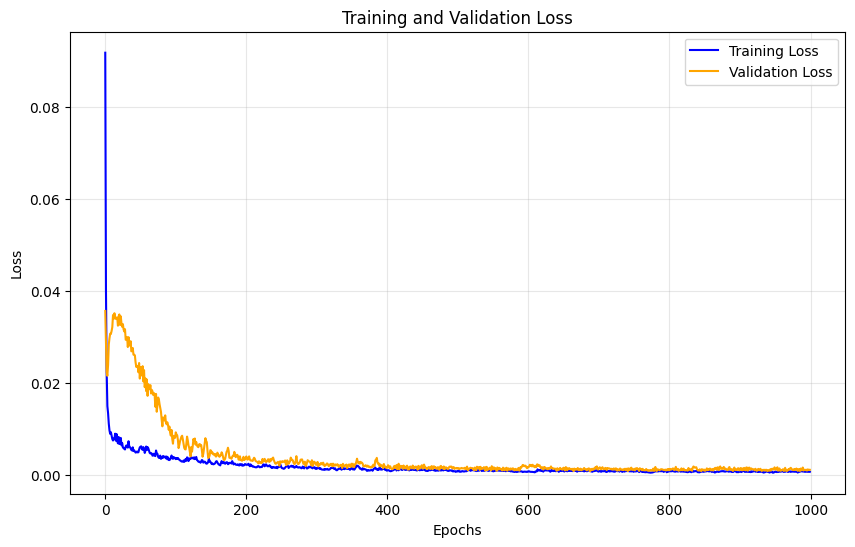

In [9]:
plot_loss(history)

# Prediction & Performance

In [27]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [ ]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/v1.4/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_matrix_2013_for_o3.csv')

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data = ctrl_data[:, :17*3]

_, X_emis_test, _, y_test = train_test_split(pred_emis_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test]) # 2가지 경계 조건에 따른 1년치 Nitrate
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 0s 14ms/step


In [29]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [30]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [31]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


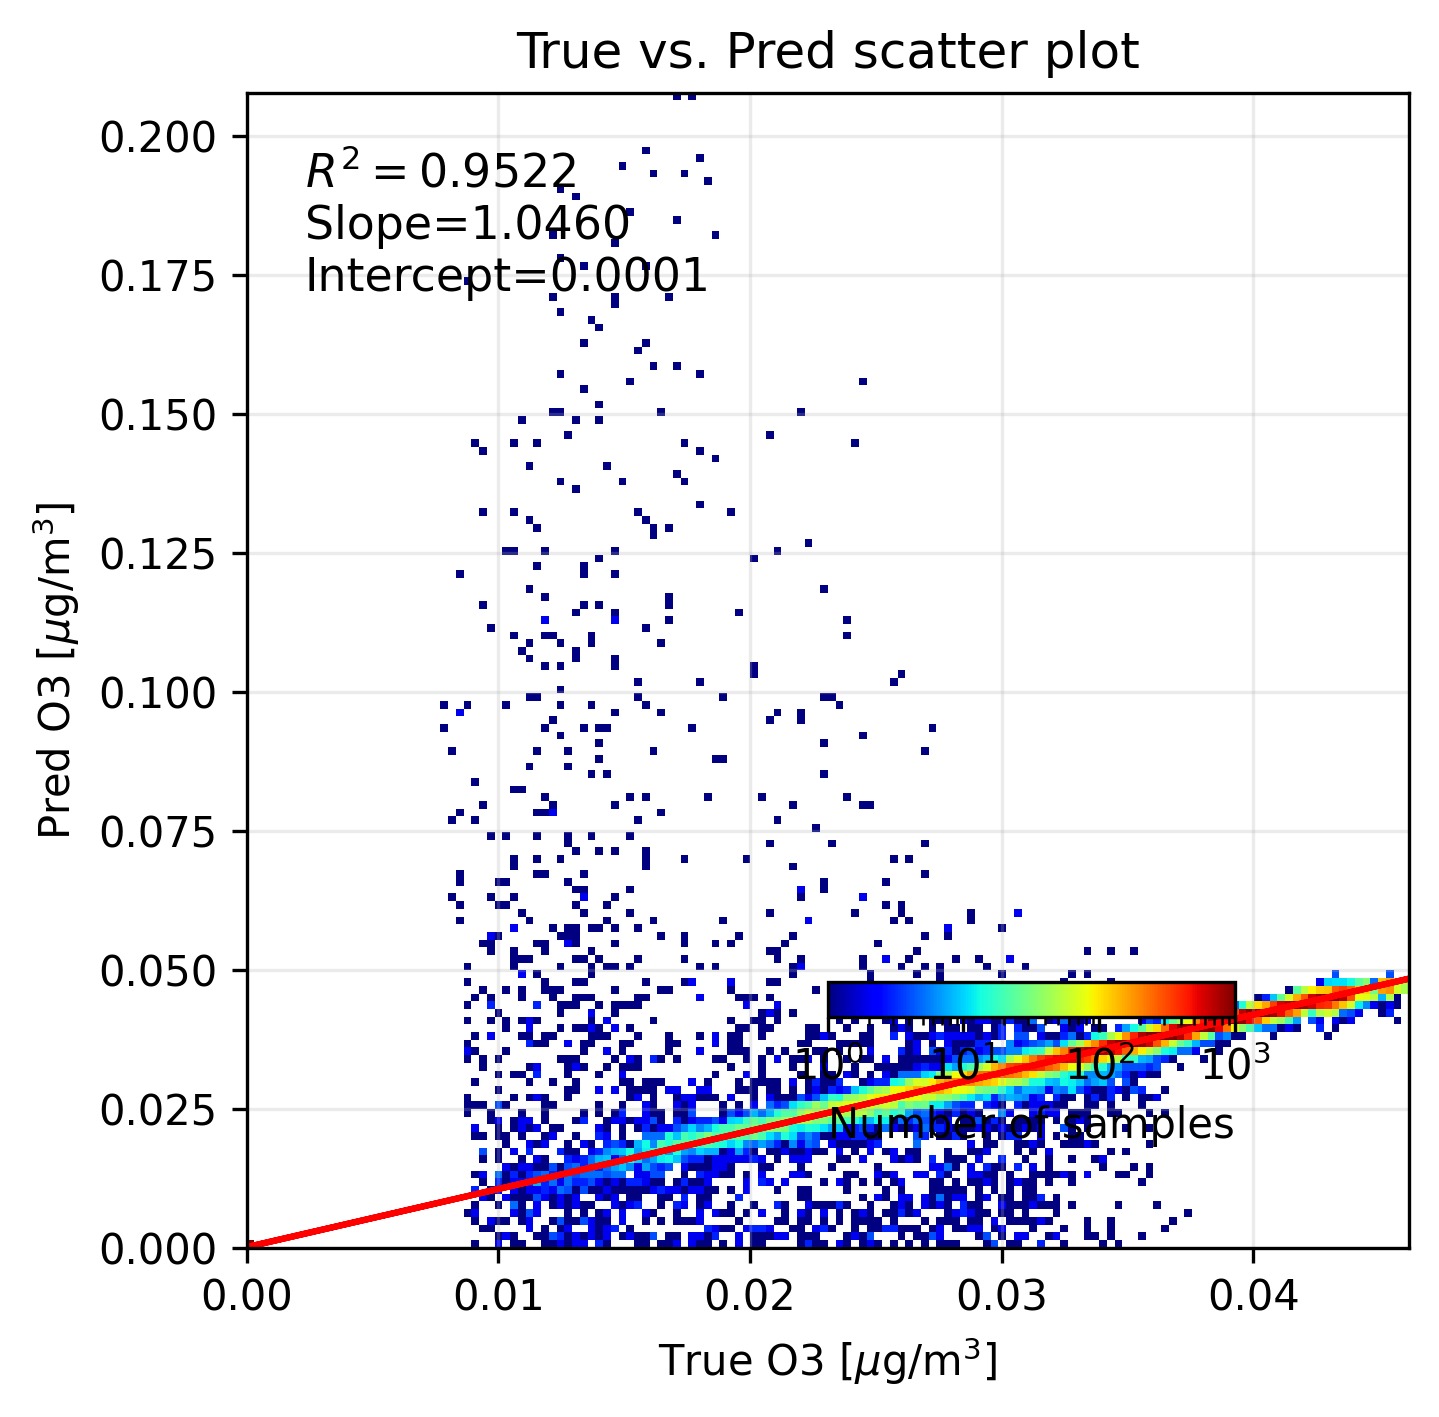

In [ ]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

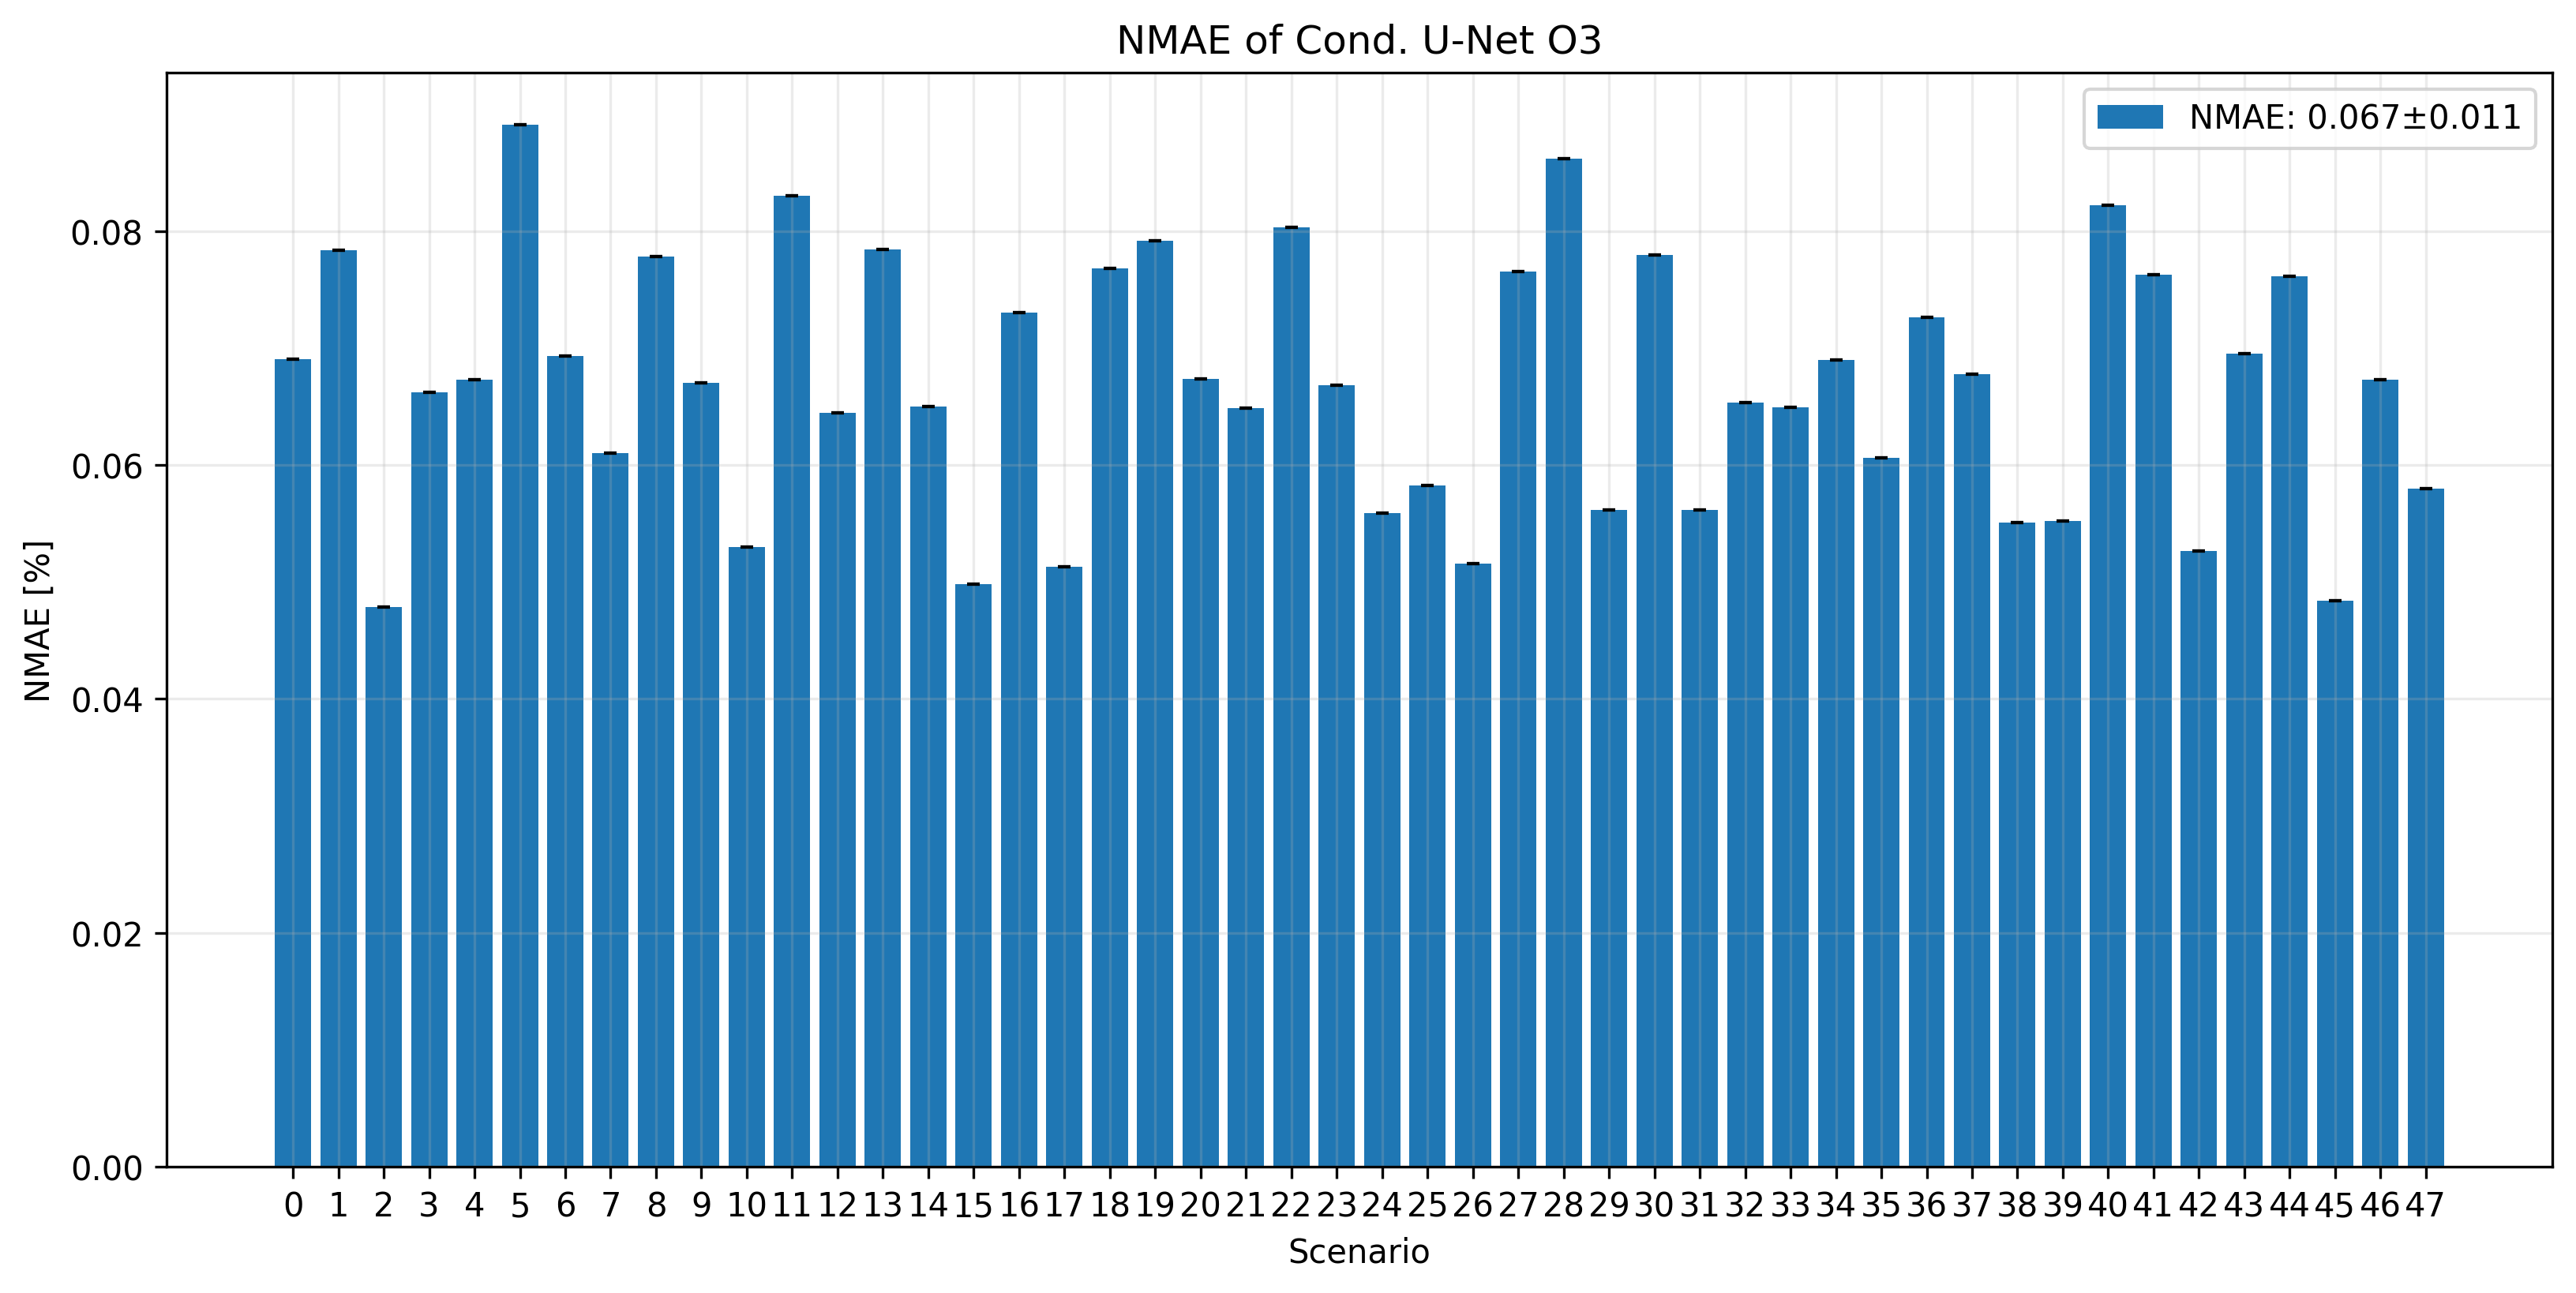

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [34]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

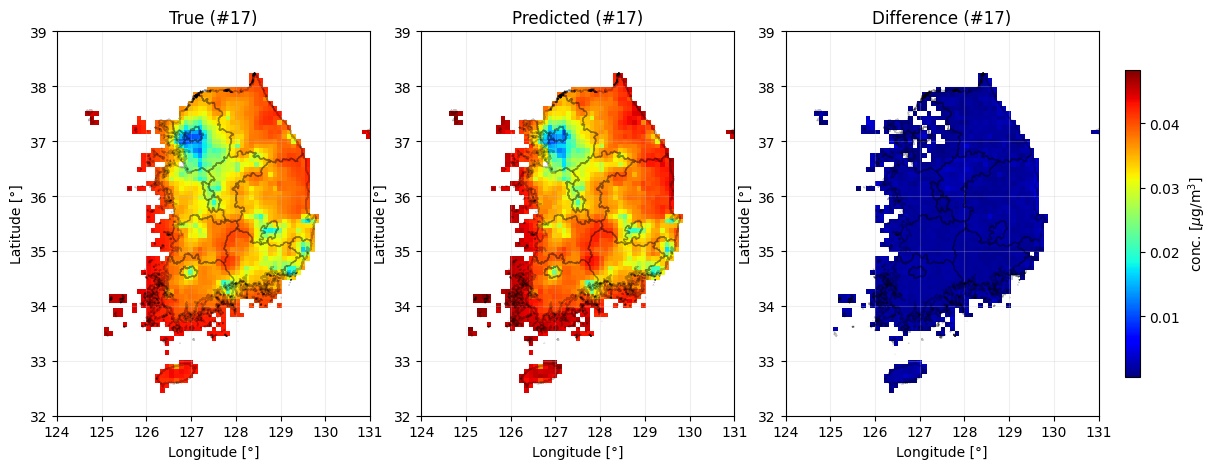

In [40]:
cmap_with_white = plt.get_cmap('jet').copy()   # 예: jet 컬러맵 복사
cmap_with_white.set_bad('white')               # 마스킹된 부분을 흰색으로

def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = [index]
    
    # (예시) "선택된 인덱스들"만 고려한 local_min/local_max
    local_min = min(y_true[indices].min(), y_pred[indices].min())
    local_max = max(y_true[indices].max(), y_pred[indices].max())
    local_diff = np.abs(y_true[indices] - y_pred[indices])
    local_max = max(local_max, local_diff.max())

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]  # (1, 3) 형태로 맞춤

    # 지도 투영 좌표 범위
    x_min = -180000 + offset_x
    x_max =  414000 + offset_x
    y_min = -585000 + offset_y
    y_max =  144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]

    # "0 이하이면 흰색"으로 표시하고 싶다면:
    threshold = 0.0005  # 또는 원하는 임계값(예: local_min 등)

    for i, idx in enumerate(indices):
        # (A) True 데이터
        data_true = y_true[idx][::-1]
        # 2) 마스킹: threshold 이하 부분을 마스크
        masked_true = np.ma.masked_where(data_true <= threshold, data_true)
        
        im_true = axes[i, 0].imshow(
            masked_true,
            cmap=cmap_with_white,          # 마스킹 컬러맵
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,                # 컬러 스케일 최소
            vmax=local_max                 # 컬러 스케일 최대
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_xlim(x_min, x_max)
        axes[i, 0].set_ylim(y_min, y_max)
        axes[i, 0].set_xticks(x_ticks)
        axes[i, 0].set_yticks(y_ticks)
        axes[i, 0].set_xticklabels(x_labels)
        axes[i, 0].set_yticklabels(y_labels)
        axes[i, 0].grid(alpha=0.25, color='silver')

        # (B) Predicted
        data_pred = y_pred[idx][::-1]
        masked_pred = np.ma.masked_where(data_pred <= threshold, data_pred)

        im_pred = axes[i, 1].imshow(
            masked_pred,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_xlim(x_min, x_max)
        axes[i, 1].set_ylim(y_min, y_max)
        axes[i, 1].set_xticks(x_ticks)
        axes[i, 1].set_yticks(y_ticks)
        axes[i, 1].set_xticklabels(x_labels)
        axes[i, 1].set_yticklabels(y_labels)
        axes[i, 1].grid(alpha=0.25, color='silver')

        # (C) Difference
        data_diff = np.abs(y_true[idx] - y_pred[idx])[::-1]
        masked_diff = np.ma.masked_where(data_diff <= threshold, data_diff)

        im_diff = axes[i, 2].imshow(
            masked_diff,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_xlim(x_min, x_max)
        axes[i, 2].set_ylim(y_min, y_max)
        axes[i, 2].set_xticks(x_ticks)
        axes[i, 2].set_yticks(y_ticks)
        axes[i, 2].set_xticklabels(x_labels)
        axes[i, 2].set_yticklabels(y_labels)
        axes[i, 2].grid(alpha=0.25, color='silver')

    # 서브플롯 간격/레이아웃 조정
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.88, 0.96])

    # (3) 단일 컬러바
    cbar = fig.colorbar(
        im_true,
        ax=axes.ravel().tolist(),
        orientation='vertical',
        fraction=0.03,
        pad=0.02,
        shrink=0.8
    )
    cbar.set_label('conc. [$\\mu \\mathrm{g}/\\mathrm{m}^3$]')

    plt.show()

# ==============================
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=17)

In [36]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

# 17번 인덱스 제거
true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


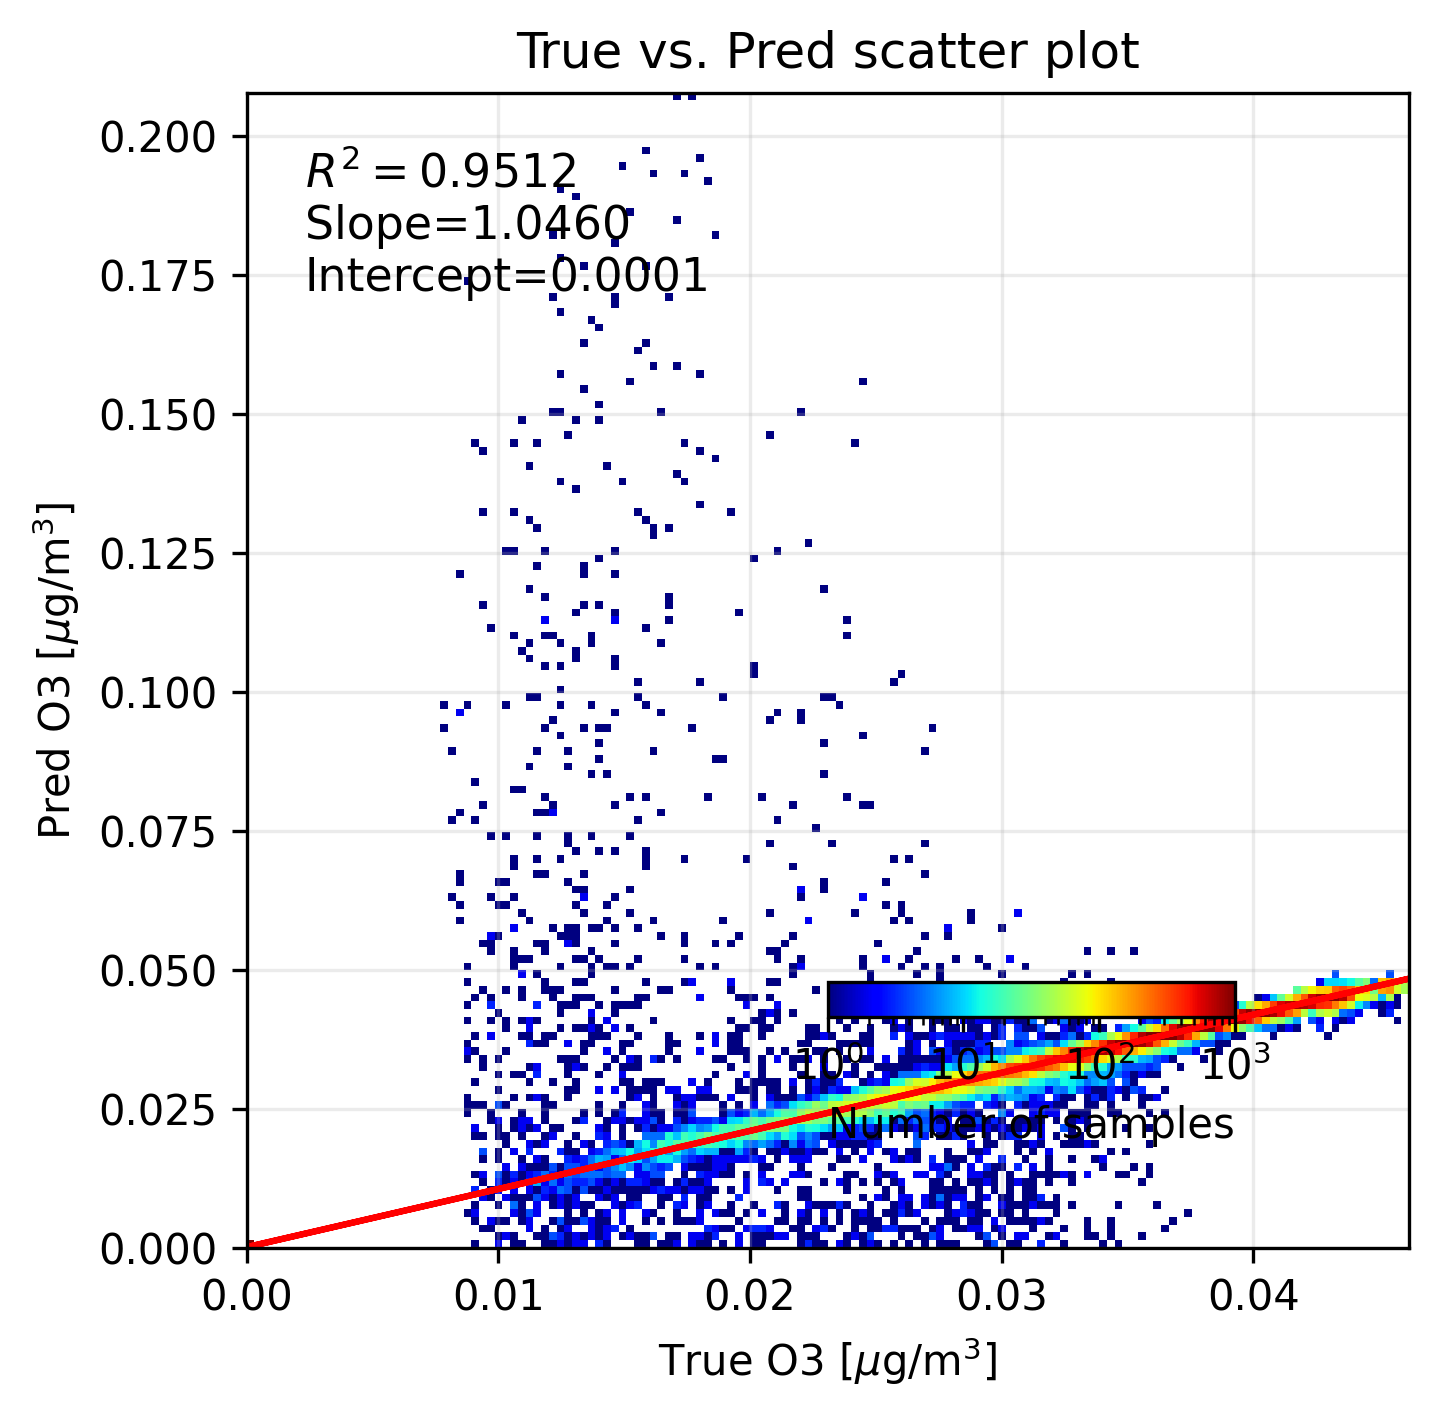

In [ ]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

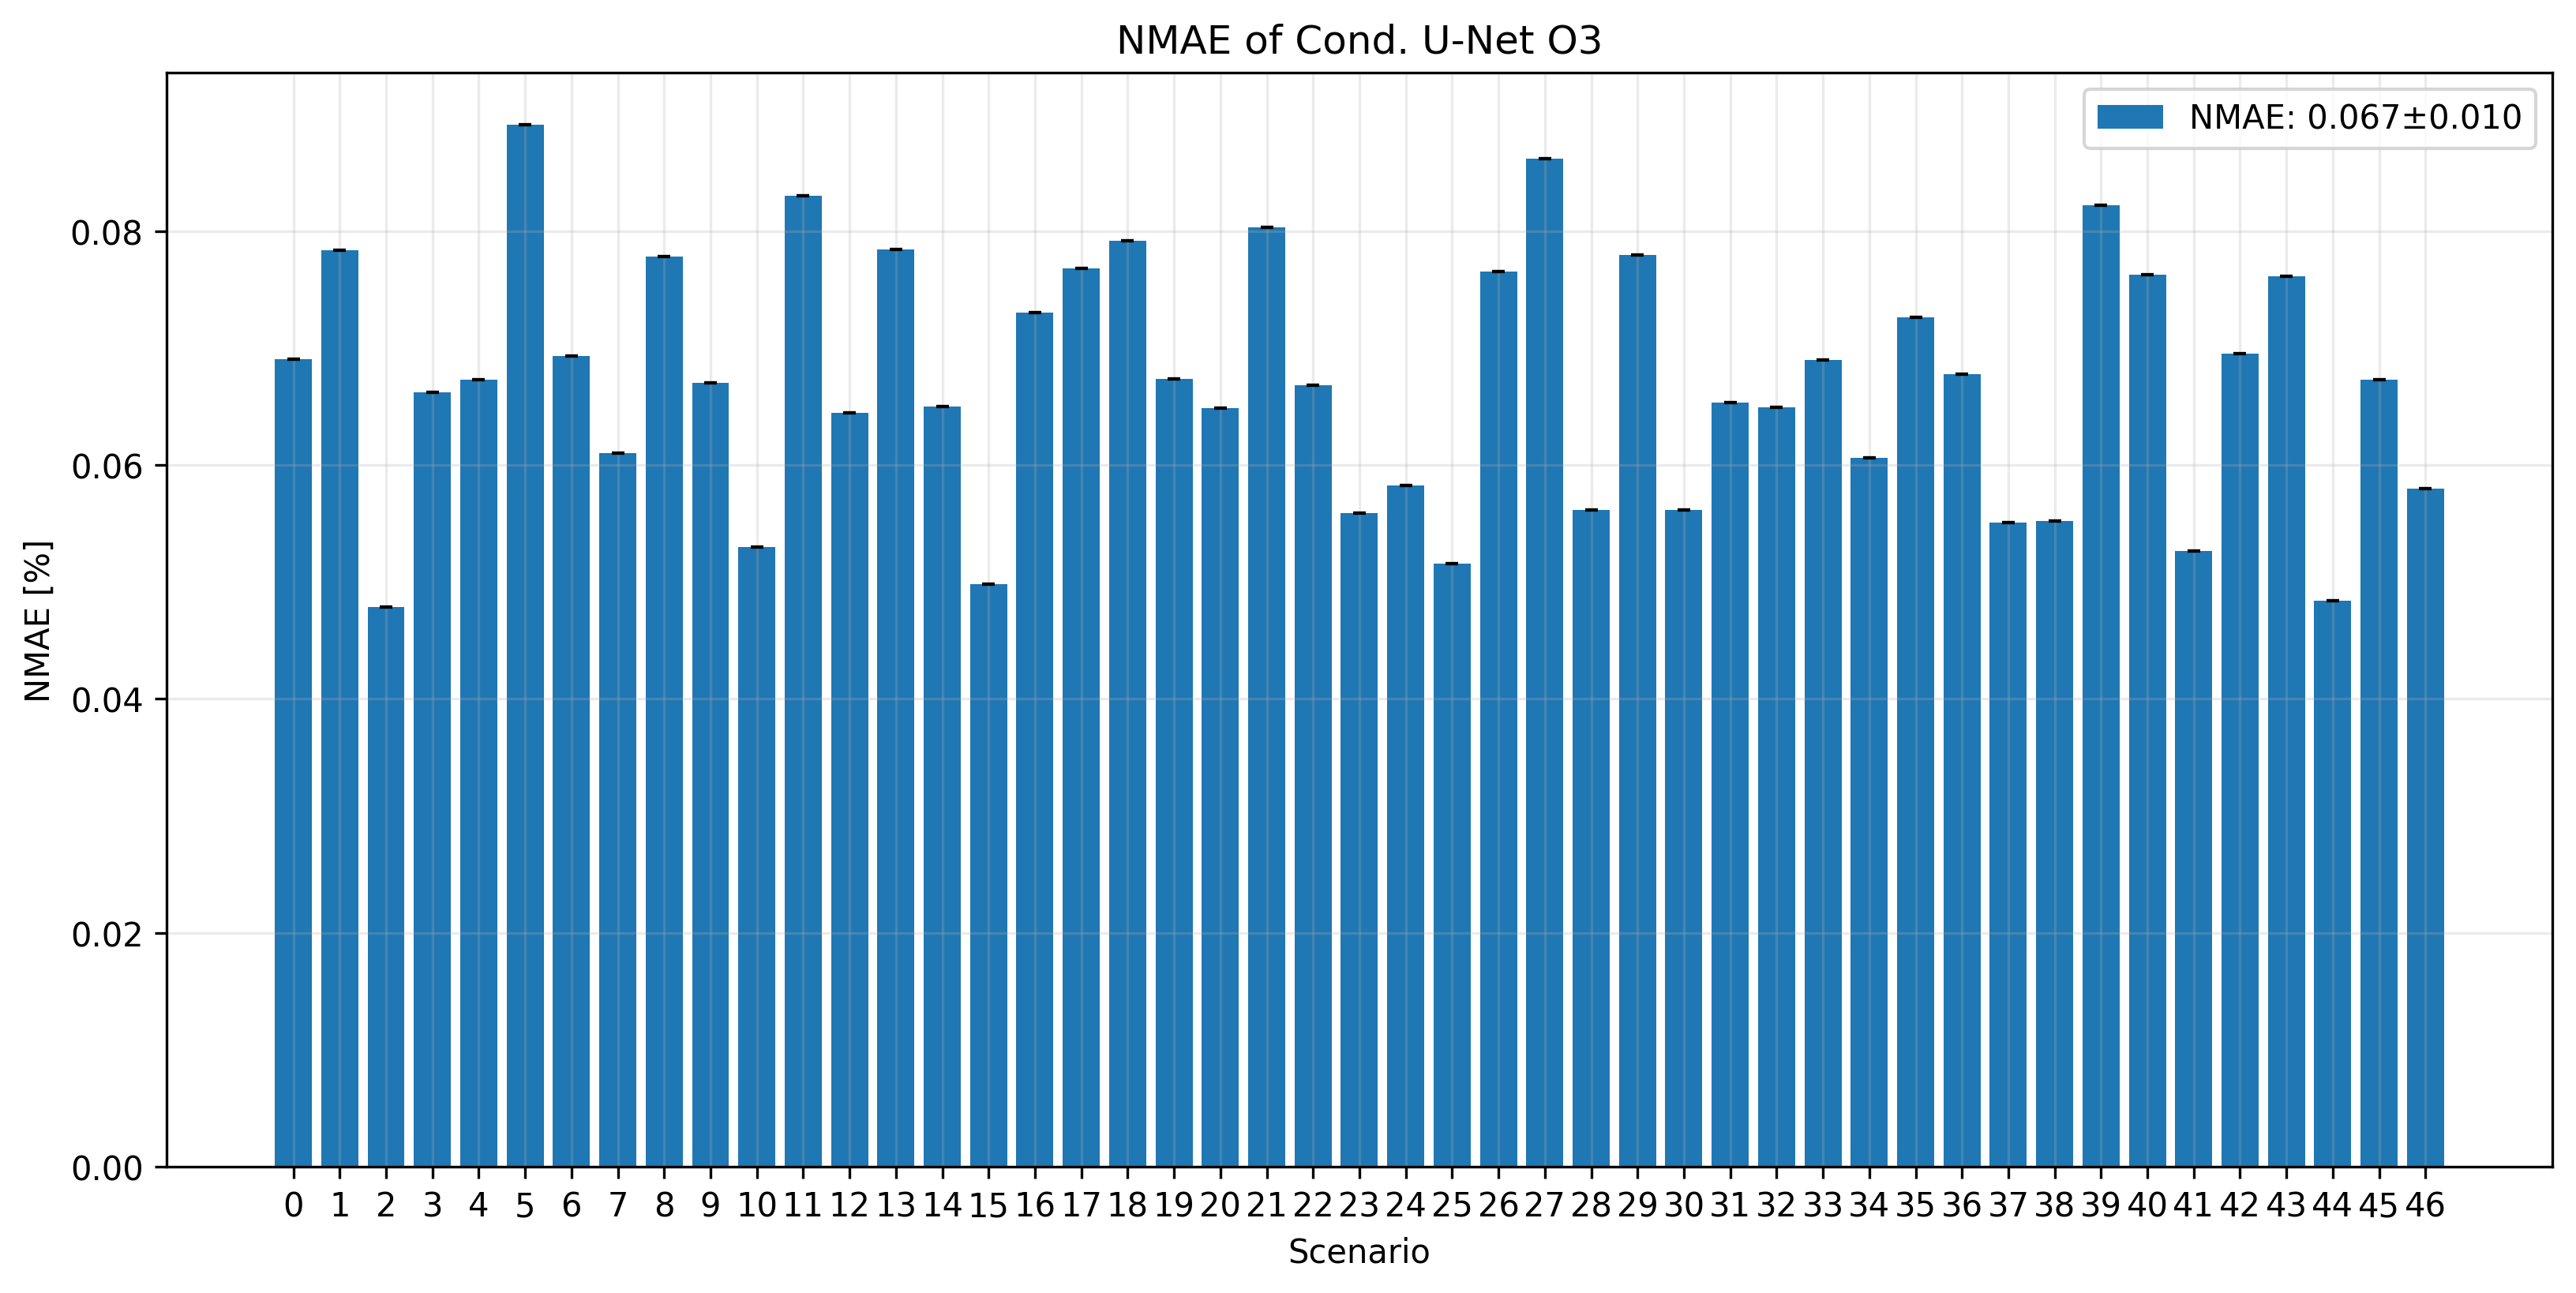

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()